# dfirNotes Investigation

**Inv Plan:** Win5mem : WinXP memory image triage

**Case:** 20150124BSK : *Suspicious IE/Java behaviour on workstation*

**Investigator:** Ben S. Knowles (bsk@dfirnotes.org)

**Response Phase:** Identification

**Refs**: Problem reported to Helpdesk in ticket [1202](https://tickets.dfirnotes.org/HD-1202), Incident case record [20150124BSK](https:ir.dfirnotes.org/INC-20150124BSK)

**Date/times of interest:** Memory image acquired 2014-04-17 11:00:53 -0400

**Evidence location:** */cases/win5mem/winxp_java6-meterpreter.vmem*, VMWare memory image

## Investigation Plan

*from 504.5 (2014) p42*

1. Which processes are communicating on the network?
2. Which process is likely run by the attacker?
3. Look for signs of pivot and identify the destination system(s)
4. What suspicious process might be root cause?
5. (extra credit) Windows triage commands to find this information from a live system.

## Work

Use *Volatility* *imageinfo* plugin to check which profile to use and verify Vol can read the memory image. Once that's settled we can build a script for a batch run, process the memory image for our first batch of results, and look at the data with *Pandas*.

In [4]:
!vol.py --plugins=/home/sosift/f/dfirnotes/ -f /cases/win5mem/winxp_java6-meterpreter.vmem --profile WinXPSP2x86 imageinfo

Volatility Foundation Volatility Framework 2.4
Determining profile based on KDBG search...

          Suggested Profile(s) : WinXPSP2x86, WinXPSP3x86 (Instantiated with WinXPSP2x86)
                     AS Layer1 : IA32PagedMemoryPae (Kernel AS)
                     AS Layer2 : FileAddressSpace (/cases/win5mem/winxp_java6-meterpreter.vmem)
                      PAE type : PAE
                           DTB : 0x349000L
                          KDBG : 0x80545ce0
          Number of Processors : 1
     Image Type (Service Pack) : 3
                KPCR for CPU 0 : 0xffdff000
             KUSER_SHARED_DATA : 0xffdf0000
           Image date and time : 2014-04-17 15:00:53 UTC+0000
     Image local date and time : 2014-04-17 11:00:53 -0400


In [6]:
## Get setup to process memory with Volatility, analyse data with Pandas, chart with matplotlib
## Charting tips from https://datasciencelab.wordpress.com/2013/12/21/beautiful-plots-with-pandas-and-matplotlib/
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt

##
case_folder = '/cases/win5mem/'
memimage = '/cases/win5mem/winxp_java6-meterpreter.vmem' 
vol_profile = 'WinXPSP2x86' ## use vol.py imageinfo if you don't know this

## Assemble the volatility commands for batch execution in a shell
## start with sift3 volatility + custom modules sample
vol24 = '/usr/bin/vol.py --plugins=/home/sosift/f/dfirnotes/ ' 
vol_cmd = vol24 + '-f ' + memimage + ' --profile=' + vol_profile

## Configure plugins and output formats, completion flags:
vol_cmd_ps = vol_cmd + ' pscsv --output=csv ' + '> ' + case_folder + 'ps.csv' + ' && echo PS CSV Done!'
vol_cmd_conns = vol_cmd + ' connscan ' + '> ' + case_folder + 'connscan.txt' + ' && echo Connscan Done!'

vol_script = case_folder + 'volscript'

with open(vol_script, 'wb') as f:
            f.write(vol_cmd_ps+'\n')
            f.write(vol_cmd_conns)

In [81]:
! /bin/sh /cases/win5mem/volscript

Volatility Foundation Volatility Framework 2.4
PS CSV Done!
Volatility Foundation Volatility Framework 2.4
Connscan Done!


Batch processing is complete. Let's pull our results in Pandas DataFrames so we can take a look, starting with the processes CSV file from the demo *pscsv* plugin. We can easily import CSV with Pandas and let it know which column is the date/time data on import, and then set the PID number field as our index. We use the Pandas df.info() function to see a summary of what we imported before continuing.

In [2]:
procs = pd.read_csv('/cases/win5mem/ps.csv', parse_dates=['Created'])
procs.set_index(['Pid'])
procs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 0 to 34
Data columns (total 4 columns):
Offset     35 non-null object
Process    35 non-null object
Pid        35 non-null int64
Created    35 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.4+ KB


Here's quick histogram of processes by process name. Only svchost, Java, VmWare, and Internet Explorer have more than one instance.

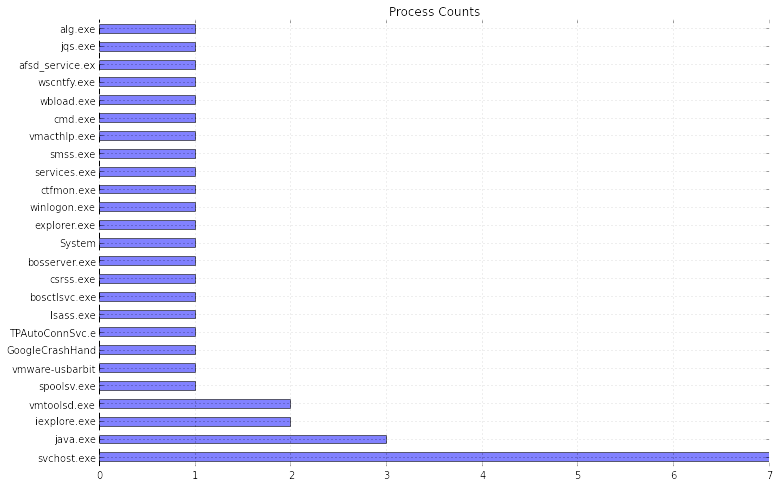

In [28]:
# Create a figure of given size
fig = plt.figure(figsize=(12,8))

# Add a subplot
ax = fig.add_subplot(111)
# Remove grid lines (dotted lines inside plot)
ax.grid(False)
# Remove plot frame
ax.set_frame_on(False)
# Pandas trick: remove weird dotted line on axis
#ax.lines[0].set_visible(False)

# Set title
ttl = title='Process Counts'
# Set color transparency (0: transparent; 1: solid)
a = 0.7
# Create a colormap
customcmap = [(x/24.0,  x/48.0, 0.05) for x in range(len(procs))]
## chart the data frame with these params
procs['Process'].sort_index().value_counts().plot(kind='barh', title=ttl, ax=ax, alpha=a)
plt.savefig('Process Counts.png', bbox_inches='tight', dpi=300)

Pandas can handle fixed width text tables almost as adroitly as CSV using the read_fwf function. We use it to load in the output of the standard Volatility connscan, set the Pid field as our index, and check import with info(). 

(FIXME) We need to get rid of one null line that is an import artifact.

In [31]:
conns = pd.read_fwf('/cases/win5mem/conns.txt')
conns.set_index(['Pid'])
conns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 4 columns):
Offset(P)         31 non-null object
Local Address     31 non-null object
Remote Address    31 non-null object
Pid               31 non-null object
dtypes: object(4)
memory usage: 1.2+ KB


Here is a quick histogram of the remote IP addresses in use, including the port numbers. Reviewing the x-axis we see common web service ports (80 and 443), Windows service ports (139), and some less obvious ones. High ports 1337, 4444, and 1648 may all be worth followup as they are less expected on a Windows XP system than the first set.

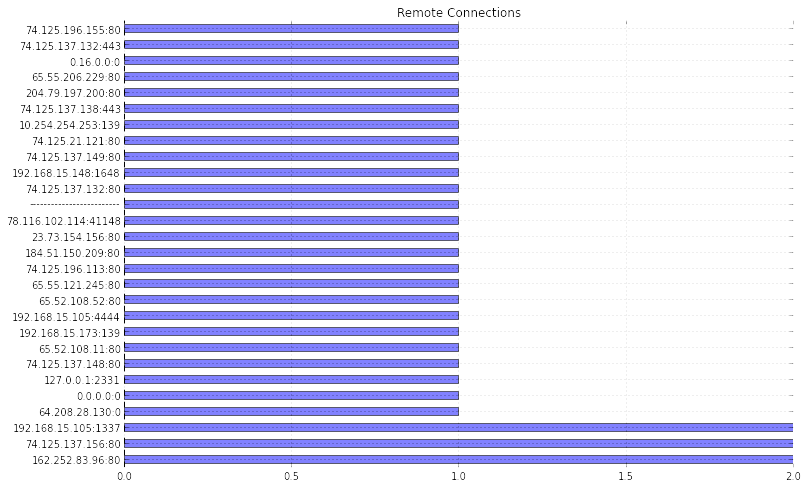

In [32]:
# Create a figure of given size
fig = plt.figure(figsize=(12,8))

# Add a subplot
ax = fig.add_subplot(111)
# Remove grid lines (dotted lines inside plot)
ax.grid(False)
# Remove plot frame
ax.set_frame_on(False)
# Pandas trick: remove weird dotted line on axis
#ax.lines[0].set_visible(False)

# Set title
ttl = title='Remote Connections'
# Set color transparency (0: transparent; 1: solid)
a = 0.7
# Create a colormap
customcmap = [(x/24.0,  x/48.0, 0.05) for x in range(len(procs))]
## chart the data frame with these params

conns['Remote Address'].sort_index().value_counts().plot(kind='barh', title=ttl, ax=ax, alpha=a)

plt.savefig('Remote Connections.png', bbox_inches='tight', dpi=300)

Let's slice out just those IE processes and see who they were talking to. We pull the process IDs from the process data and use it to look for processes with connection in the connection data from *connscan*.

In [92]:
procs[procs.Process=="iexplore.exe"]

,Offset,Process,Created
Pid,,,
308,0x82033020,iexplore.exe,2014-04-17 14:41:31
2576,0x82100020,iexplore.exe,2014-04-17 14:41:37


In [34]:
## not all processes have connections, but this one does
ie_conns = conns[conns.Pid == '2576']

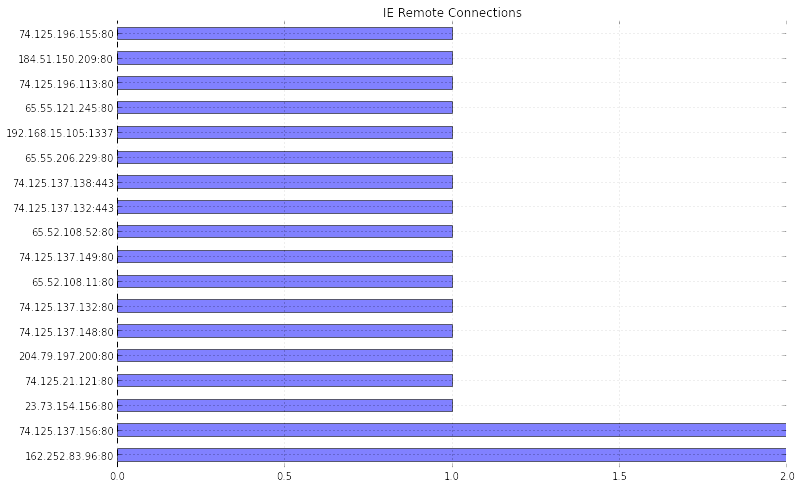

In [36]:
# Create a figure of given size
fig = plt.figure(figsize=(12,8))

# Add a subplot
ax = fig.add_subplot(111)
# Remove grid lines (dotted lines inside plot)
ax.grid(False)
# Remove plot frame
ax.set_frame_on(False)
# Pandas trick: remove weird dotted line on axis
#ax.lines[0].set_visible(False)

# Set title
ttl = title='IE Remote Connections'
# Set color transparency (0: transparent; 1: solid)
a = 0.7
# Create a colormap
customcmap = [(x/24.0,  x/48.0, 0.05) for x in range(len(procs))]
## chart the data frame with these params

conns['Remote Address'].sort_index().value_counts()
ie_conns['Remote Address'].sort_index().value_counts().plot(kind='barh', title=ttl, ax=ax, alpha=a)

plt.savefig('IE Remote Connections.png', bbox_inches='tight', dpi=300)


We can see that IE was talking to several Internet addresses on web service ports and one local (RFC1918) address on 1337. And Java?

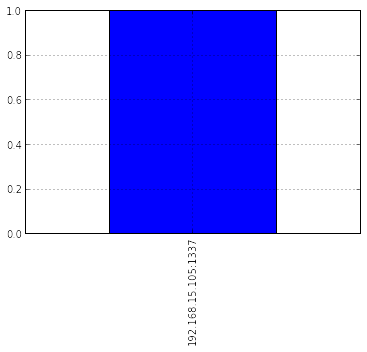

In [100]:
## not all processes have connections, this one does
java_conns = conns[conns.Pid=='3156']
java_conns['Remote Address'].sort_index().value_counts().plot(kind='bar')

One Java process was also communicating with the unknown 1337 service on the local network.

# Results

## Complete Process List and Connection List:

In [69]:
procs

,Offset,Process,Pid,Created
0,0x825c8660,System,4,1970-01-01 00:00:00
1,0x82208020,smss.exe,384,2014-04-09 07:47:06
2,0x821be3b8,csrss.exe,620,2014-04-09 07:47:12
3,0x82444da0,winlogon.exe,700,2014-04-09 07:47:13
4,0x821bcda0,services.exe,744,2014-04-09 07:47:14
5,0x824ee4b0,lsass.exe,756,2014-04-09 07:47:14
6,0x8208aa78,vmacthlp.exe,912,2014-04-09 07:47:14
7,0x821fd6b8,svchost.exe,936,2014-04-09 07:47:15
8,0x82240320,svchost.exe,1004,2014-04-09 07:47:15
9,0x820f6da0,svchost.exe,1320,2014-04-09 07:47:16


In [38]:
conns

,Offset(P),Local Address,Remote Address,Pid
0,----------,-------------------------,-------------------------,---
1,0x01e61bf8,192.168.15.148:2358,162.252.83.96:80,2576
2,0x01e7ec18,192.168.15.148:2345,23.73.154.156:80,2576
3,0x01ecb8e0,0.0.0.0:0,0.0.0.0:0,2179774712
4,0x01edebc0,10.254.254.253:139,192.168.15.148:1648,4
5,0x01eef9d0,127.0.0.1:5152,127.0.0.1:2331,640
6,0x01f08e68,192.168.15.148:2366,192.168.15.173:139,0
7,0x01f0be68,192.168.15.148:2352,74.125.137.132:443,2576
8,0x01f0e3a0,192.168.15.148:2353,74.125.137.156:80,2576
9,0x020845d0,8.44.65.130:61057,78.116.102.114:41148,0


### Suspicious Processes

Internet Explorer and Java processes were communicating with an unidentified services on a local network host. Those processes and the host they were communicating with are worth further investigation to get to the bottom of the supicious activity in the evidence presented. 

In [102]:
procs[procs.Process=="iexplore.exe"]

,Offset,Process,Created
Pid,,,
308,0x82033020,iexplore.exe,2014-04-17 14:41:31
2576,0x82100020,iexplore.exe,2014-04-17 14:41:37


In [104]:
procs[procs.Process=="java.exe"]

,Offset,Process,Created
Pid,,,
3156,0x81ee8990,java.exe,2014-04-17 14:42:15
476,0x81ec1020,java.exe,2014-04-17 14:42:20
3472,0x81ec06a8,java.exe,2014-04-17 14:42:20


## Conclusion

There are definite signs of supicious activity in the evidence gathered so far. Recommend proceding with response efforts in accordance with the IRP: **Contain** the desktop system and gather more evidence from other sources.